# Use Pandas to  analyze CSV files of seismic rays 

## Explore the pandas functions, and validate testing the algorithms.

###  Fei Zhang
### Last updated 2019-06-14

In [1]:
!pwd

/g/data/ha3/fxz547/Githubz/passive-seismic/notebooks


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
inputcsv = '/g/data/ha3/fxz547/Githubz/passive-seismic/tests/testdata/100K_ensemble.p.txt'
phase='P'

csv_data = pd.read_csv(inputcsv, sep='\s+', header='infer')

In [4]:
csv_data.head()

,#eventID,originTimestamp,mag,originLon,originLat,originDepthKm,net,sta,cha,pickTimestamp,...,az,baz,distance,ttResidual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma
0,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,KNA,BHZ,1.197052e+09,...,232.647636,55.399525,18.838486,-0.134955,0.0,0.0,0.0,0.0,0,0
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,QLP,BHZ,1.197052e+09,...,179.947115,359.941088,21.923102,1.734943,0.0,0.0,0.0,0.0,0,0
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,RMQ,BHZ,1.197052e+09,...,169.186187,347.946731,22.255710,3.240389,0.0,0.0,0.0,0.0,0,0
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,WSI,BHZ,1.197052e+09,...,256.588695,79.595928,24.286730,-0.985012,0.0,0.0,0.0,0.0,0,0
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,ARMA,BHZ,1.197052e+09,...,165.616858,343.327251,26.681831,2.491256,0.0,0.0,0.0,0.0,0,0


In [5]:
from seismic.traveltime.cluster_grid import Grid2
import seismic.traveltime.sort_rays as sortrays

In [6]:
column_name_map={
    "originLon": "source_lon",
    "originLat": "source_lat",
    "originDepthKm":"source_depth_km",
    "stationLon": "station_lon",
    "stationLat": "station_lat",
    "ttResidual":  "tt_residual"
}

# rename the columns
csv_data.rename(columns=column_name_map, inplace=True)

# apply filters

csv_data = sortrays.apply_filters(csv_data, phase)

The initial CSV size= (99999, 23)
After residual cutoff, CSV size= (91229, 24)
After qualityMeasureCWT, CSV size= (84442, 24)
After qualityMeasureSlope, CSV size= (82639, 24)
After nSigma, CSV size= (82551, 24)
Final Number of P Rays =  82551 ['AU_KNA_smi:local/102160r49', 'IR_QLP_smi:local/102160r49', 'AU_RMQ_smi:local/102160r49', 'GE_WSI_smi:local/102160r49', 'GE_ARMA_smi:local/102160r49']


In [7]:
csv_data.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,baz,distance,tt_residual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma,manual_picks_flag
0,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,KNA,BHZ,1.197052e+09,...,55.399525,18.838486,-0.134955,0.0,0.0,0.0,0.0,0,0,1
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,QLP,BHZ,1.197052e+09,...,359.941088,21.923102,1.734943,0.0,0.0,0.0,0.0,0,0,1
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,RMQ,BHZ,1.197052e+09,...,347.946731,22.255710,3.240389,0.0,0.0,0.0,0.0,0,0,1
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,WSI,BHZ,1.197052e+09,...,79.595928,24.286730,-0.985012,0.0,0.0,0.0,0.0,0,0,1
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,ARMA,BHZ,1.197052e+09,...,343.327251,26.681831,2.491256,0.0,0.0,0.0,0.0,0,0,1


In [8]:
# the csv size after filters applied:
csv_data.shape

(82551, 24)

# Map seismic events and stations onto a grid model, then cluster sort rays

In [9]:
mygrid = Grid2(param_file="/g/data/ha3/fxz547/Githubz/passive-seismic/seismic/traveltime/param1x1")


In [10]:
import ellipcorr

from obspy.geodetics import gps2dist_azimuth, locations2degrees
import logging
from seismic.traveltime import pslog
from seismic.traveltime.cluster_grid import Grid2

# DPI = asin(1.0) / 90.0
# R2D = 90. / asin(1.)
# FLOAT_FORMAT = '%.4f'

log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

def compute_ellipticity_corr(arrival_phase, ev_latitude, ev_longitude, ev_depth_km, sta_latitude, sta_longitude,
                             degrees_to_source):
    """
    Utility function to compute ellipticity correction.

    :param arrival_phase: P or S
    :param ev_latitude:  event lat
    :param ev_longitude: event long
    :param ev_depth_km: event depth in km
    :param sta_latitude: station lat
    :param sta_longitude: station long
    :param degrees_to_source: degree to source
    :return: ellipticity correction float value
    """
    myazim = gps2dist_azimuth(ev_latitude, ev_longitude, sta_latitude, sta_longitude)[1]  # [1] shall be taken
    # see https://docs.obspy.org/_modules/obspy/geodetics/base.html#gps2dist_azimuth
    # this function returns 3 values (Great_circle_distance_in_m, azimuth_A->B_in_degrees, azimuth_B->A_in degrees)

    log.debug("Check input params to ellipticity_corr = %s, %s, %s, %s, %s", arrival_phase, degrees_to_source,
              ev_depth_km, 90 - ev_latitude, myazim)

    ellipticity_corr = ellipcorr.ellipticity_corr(
        phase=arrival_phase,
        edist=degrees_to_source,
        edepth=ev_depth_km,
        ecolat=90 - ev_latitude,  # conversion to co-latitude
        azim=myazim
    )

    log.debug("ellipticity_corr = %s", ellipticity_corr)

    return ellipticity_corr


def sort_cluster(csv_data, phase, outputcsv):
    
    
    print("Initial csv_data size", csv_data.shape)
    
    csv_data['source_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.source_lat, x.source_lon, 1000 * (x.source_depth_km))[0], axis=1)

    csv_data['station_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.station_lat, x.station_lon, 0.0)[0], axis=1)

    csv_data['observed_tt'] = csv_data.pickTimestamp - csv_data.originTimestamp

    # cluster_data.to_csv(outputcsv+"_debug.CSV", header=True, index=False, sep=',')

    log.info('Begin Sorting arrivals.')

    # groupby automatically sorts
    med = csv_data.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()
    
    print("The medium observed_tt rows:  ", med.shape)

    final_df = pd.merge(csv_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True, right_index=True)

    print("The merged csv_data and med size", final_df.shape)
    # use the following to keep only unique  prim_key: ['source_block', 'station_block']
    # final_df.drop_duplicates(subset=['source_block', 'station_block'],keep='first', inplace=True)
    # Note that some near-by stations may be cluster into one station_block_number, if want to keep stations try
    # final_df.drop_duplicates(subset=['source_block', 'station_block', 'station_code'],keep='first', inplace=True)

    final_df.drop_duplicates(subset=['source_block', 'station_block'], keep='first', inplace=True)
    
    print("the size of the final_df after drop_duplicates on source_block, station_block", final_df.shape)

    # elliptic correction to the  observed_travel_time;

    final_df['locations_to_degrees'] = final_df.apply(lambda x: locations2degrees(x.source_lat, x.source_lon,
                                                                                  x.station_lat, x.station_lon), axis=1)
    final_df['my_azim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                    x.station_lat, x.station_lon)[1], axis=1)

    final_df['my_bazim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                     x.station_lat, x.station_lon)[2], axis=1)
    final_df['ellipticity_corr'] = final_df.apply(lambda x:
                                                  compute_ellipticity_corr(phase, x.source_lat, x.source_lon,
                                                                           x.source_depth_km,
                                                                           x.station_lat, x.station_lon, x.distance),
                                                  axis=1)

    final_df['observed_tt'] = final_df.observed_tt + final_df.ellipticity_corr

    # make sure the originDepth/source_depth is in KM for required by inversion program

    final_df.to_csv(outputcsv, header=True, index=False, sep=',')  # use comma separator,

    # inpdf.to_csv(outputcsv, header=True, index=False, sep=' ')   # mismatch columns in space-delimited csv file as the NaN => empty space !

    # prepare for inversion-program input
    
    if phase == 'P':
        final_df['P_or_S'] = 1
    elif phase == 'S':
        final_df['P_or_S'] = 2
    else:
        raise Exception("Phase must be P or S !!!")

    final_df['event_number'] = final_df.apply(lambda x: int(x.originTimestamp), axis=1)

    # the following values are required for inversion program. the event_number defined as int(originTimestamp)
    # the columns must be in the order:
    required_columns = ['source_block', 'station_block', 'tt_residual', 'event_number',
                        'source_lon', 'source_lat', 'source_depth_km',
                        'station_lon', 'station_lat', 'observed_tt', 'locations_to_degrees', 'P_or_S']

    pdf4inv = final_df[required_columns]

    inv_txt = "%s_inv.txt" % outputcsv
    pdf4inv.to_csv(inv_txt, header=False, index=False, sep=' ', float_format='%.6f')  # space delimitted txt file

    print("Output CSV files = ",outputcsv, inv_txt)
    
    return (final_df, pdf4inv)

In [11]:
pdf1, pdf4 = sort_cluster(csv_data, phase, "%s_sort_cluster.csv"%phase)

Initial csv_data size (82551, 24)
The medium observed_tt rows:   (36393, 3)
The merged csv_data and med size (44252, 27)
the size of the final_df after drop_duplicates on source_block, station_block (36393, 27)
Output CSV files =  P_sort_cluster.csv P_sort_cluster.csv_inv.txt


In [12]:
pdf1.head(1)

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,manual_picks_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
63889,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,II,TAU,BHZ,1.283532e+09,...,0,17085,17216,252.51243,17.937228,262.955847,99.962177,-0.14757,1,1283531746


In [13]:
pdf4.head(2)

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
63889,17085,17216,0.949630,1283531746,171.984919,-43.37618,2.098619,147.3200,-42.9089,252.512430,17.937228,1
63619,17085,19192,-1.956863,1283531746,171.984919,-43.37618,2.098619,145.4906,-37.5714,281.680508,20.873575,1


In [14]:
print(pdf1.shape, pdf4.shape)

(36393, 33) (36393, 12)


# Do the clustering and sorting of pdf1 again, should converge to the same CSV.

In [15]:
# apply the same function

pdf1_A, pdf4_A = sort_cluster(pdf1, phase, "%s_sort_cluster_A.csv"%phase)

Initial csv_data size (36393, 33)
The medium observed_tt rows:   (36393, 3)
The merged csv_data and med size (36393, 33)
the size of the final_df after drop_duplicates on source_block, station_block (36393, 33)
Output CSV files =  P_sort_cluster_A.csv P_sort_cluster_A.csv_inv.txt


In [16]:
print(pdf1_A.shape, pdf4_A.shape)

(36393, 33) (36393, 12)


In [17]:
pdf1_A.head(1)

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,manual_picks_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
63889,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,II,TAU,BHZ,1.283532e+09,...,0,17085,17216,252.51243,17.937228,262.955847,99.962177,-0.14757,1,1283531746


In [18]:
# how to compare the vaules of two pdf dataframes pdf1 and pdf1_A??

pdf1['#eventID'].isin(pdf1_A['#eventID']).value_counts()

True    36393
Name: #eventID, dtype: int64

In [19]:
pdf1_A['#eventID'].isin(pdf1['#eventID']).value_counts()

True    36393
Name: #eventID, dtype: int64

# Analyse the Algorithm

In [20]:

csv_data.shape

(82551, 27)

In [21]:
med = csv_data.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()
    
print("The med shape:  ", med.shape)


The med shape:   (36393, 3)


In [22]:
med.head()

,source_block,station_block,observed_tt
0,17085,17216,252.66
1,17085,19192,281.80
2,17085,19379,255.26
3,17085,19919,263.76
4,17085,19920,263.38


In [23]:
csv_data.loc[csv_data.source_block==17085][['source_block', 'station_block', 'observed_tt']].sort_values(by='station_block')

,source_block,station_block,observed_tt
63889,17085,17216,252.66
63619,17085,19192,281.80
63612,17085,19379,255.26
63614,17085,19919,263.76
63615,17085,19919,263.79
63613,17085,19920,263.38
63657,17085,20029,496.06
63616,17085,20278,276.51
63653,17085,20755,485.18
63652,17085,20755,485.16


In [24]:
# Check the merged final_pdf
print("csv_data.shape", csv_data.shape)
final_df = pd.merge(csv_data, med, how='right',
                    on=['source_block', 'station_block', 'observed_tt'],
                    sort=True, right_index=True)

print("The final_df (merged csv_data and med) size =", final_df.shape)

csv_data.shape (82551, 27)
The final_df (merged csv_data and med) size = (44252, 27)


In [25]:
 
src_bn=17085; sta_bn=17216 # only 1

src_bn=17085; sta_bn=24209 # 8 rays in cluster

src_bn=17085; sta_bn=7803713 # 3 rows

src_bn=17085; sta_bn=7802837  # 5 rows

csv_data.loc[(csv_data.source_block==src_bn) & (csv_data.station_block==sta_bn), ['source_block', 'station_block', 'observed_tt']].sort_values(by='observed_tt')

,source_block,station_block,observed_tt
63754,17085,7802837,776.46
63757,17085,7802837,777.01
63760,17085,7802837,777.01
63758,17085,7802837,777.06
63759,17085,7802837,777.06


In [26]:
# compare with the selection result in med dataframe

med.loc[(med.source_block==src_bn) & (med.station_block==sta_bn) ]

,source_block,station_block,observed_tt
114,17085,7802837,777.01


In [27]:
# The final_df has many duplicate rows in keys ['source_block', 'station_block', 'observed_tt'] due to duplications in catalogues

# for example, at src_bn=17085; sta_bn=7802837  # 5 rows

# 	source_block 	station_block 	observed_tt
# 63757 	17085 	7802837 	777.01
# 63760 	17085 	7802837 	777.01

In [28]:

final_df.loc[(final_df.source_block==src_bn) & (final_df.station_block==sta_bn), ['source_block', 'station_block', 'observed_tt']].sort_values(by='observed_tt')

,source_block,station_block,observed_tt
63757,17085,7802837,777.01
63760,17085,7802837,777.01


In [29]:
# now let's drop the duplicates:

final_df.drop_duplicates(subset=['source_block', 'station_block'], keep='first', inplace=True)

In [30]:
# only one will be left 
final_df.loc[(final_df.source_block==src_bn) & (final_df.station_block==sta_bn), ['source_block', 'station_block', 'observed_tt']].sort_values(by='observed_tt')

,source_block,station_block,observed_tt
63757,17085,7802837,777.01


In [31]:
final_df.shape

(36393, 27)

<Figure size 432x288 with 0 Axes>

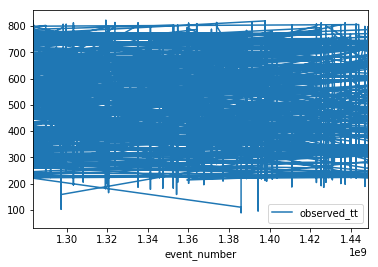

In [32]:
plt.figure(); pdf1.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

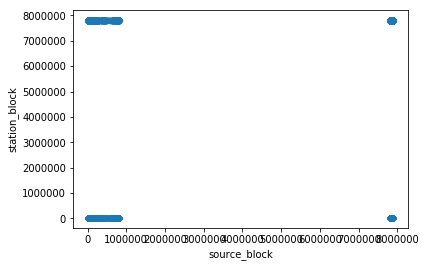

In [33]:
plt.figure(); pdf1.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

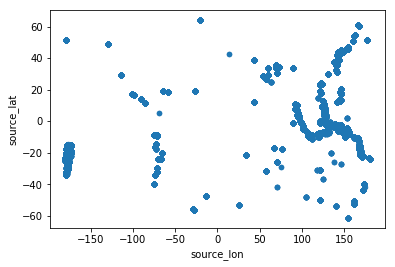

In [34]:
plt.figure(); pdf1.plot.scatter(x='source_lon', y='source_lat')

<Figure size 432x288 with 0 Axes>

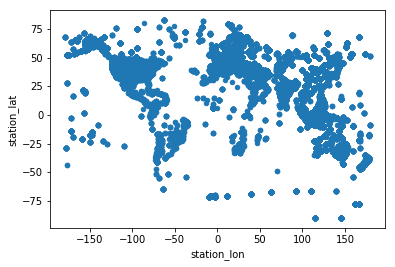

In [35]:
plt.figure(); pdf1.plot.scatter(x='station_lon', y='station_lat')

In [36]:
 med = pdf1.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [37]:
med.head()

,source_block,station_block,observed_tt
0,17085,17216,252.66
1,17085,19192,281.80
2,17085,19379,255.26
3,17085,19919,263.76
4,17085,19920,263.38


In [38]:
med.shape

(36393, 3)

In [39]:
pdf1.shape

(36393, 33)

In [40]:
pdf3=csv_data.groupby(by=['source_block', 'station_block']).count()

In [41]:
pdf3.shape

(36393, 25)

In [42]:
pdf3.head()

#eventID  originTimestamp  mag  source_lon  \
source_block station_block                                               
17085        17216                 1                1    1           1   
             19192                 1                1    1           1   
             19379                 1                1    1           1   
             19919                 2                2    2           2   
             19920                 1                1    1           1   

                            source_lat  source_depth_km  net  sta  cha  \
source_block station_block                                               
17085        17216                   1                1    1    1    1   
             19192                   1                1    1    1    1   
             19379                   1                1    1    1    1   
             19919                   2                2    2    2    2   
             19920                   1                1    1    1    1   

                            pickTimestamp     ...       distance  tt_residual  \
source_block station_block                    ...                               
17085        17216                      1     ...              1            1   
             19192                      1     ...              1            1   
             19379                      1     ...              1            1   
             19919                      2     ...              2            2   
             19920                      1     ...              1            1   

                            snr  qualityMeasureCWT  domFreq  \
source_block station_block                                    
17085        17216            1                  1        1   
             19192            1                  1        1   
             19379            1                  1        1   
             19919            2                  2        2   
             19920            1                  1        1   

                            qualityMeasureSlope  bandIndex  nSigma  \
source_block station_block                                           
17085        17216                            1          1       1   
             19192                            1          1       1   
             19379                            1          1       1   
             19919                            2          2       2   
             19920                            1          1       1   

                            manual_picks_flag  observed_tt  
source_block station_block                                  
17085        17216                          1            1  
             19192                          1            1  
             19379                          1            1  
             19919                          2            2  
             19920                          1            1  

[5 rows x 25 columns]

In [43]:
pdf4=pdf3[(pdf3['tt_residual']>=2)]  # more than one ray in the source->station set of rays

In [44]:
pdf4.shape

(14570, 25)

In [45]:
pdf4.tail()

#eventID  originTimestamp  mag  source_lon  \
source_block station_block                                               
7874268      7804693               2                2    2           2   
             7804793               2                2    2           2   
             7805052               2                2    2           2   
             7805097               2                2    2           2   
             7805239               2                2    2           2   

                            source_lat  source_depth_km  net  sta  cha  \
source_block station_block                                               
7874268      7804693                 2                2    2    2    2   
             7804793                 2                2    2    2    2   
             7805052                 2                2    2    2    2   
             7805097                 2                2    2    2    2   
             7805239                 2                2    2    2    2   

                            pickTimestamp     ...       distance  tt_residual  \
source_block station_block                    ...                               
7874268      7804693                    2     ...              2            2   
             7804793                    2     ...              2            2   
             7805052                    2     ...              2            2   
             7805097                    2     ...              2            2   
             7805239                    2     ...              2            2   

                            snr  qualityMeasureCWT  domFreq  \
source_block station_block                                    
7874268      7804693          2                  2        2   
             7804793          2                  2        2   
             7805052          2                  2        2   
             7805097          2                  2        2   
             7805239          2                  2        2   

                            qualityMeasureSlope  bandIndex  nSigma  \
source_block station_block                                           
7874268      7804693                          2          2       2   
             7804793                          2          2       2   
             7805052                          2          2       2   
             7805097                          2          2       2   
             7805239                          2          2       2   

                            manual_picks_flag  observed_tt  
source_block station_block                                  
7874268      7804693                        2            2  
             7804793                        2            2  
             7805052                        2            2  
             7805097                        2            2  
             7805239                        2            2  

[5 rows x 25 columns]

In [46]:
# select rows
rowmask= (pdf1['source_block'] == 7875846) & (pdf1['station_block']==7803235)  #select certain rows
pdf5=pdf1.loc[ rowmask ]

In [47]:
pdf5.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,manual_picks_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number


In [48]:
# iloc[] select by row and column numbers as in the CSV table
# loc[] select by index OR by boolean or conditional lookup

# .iloc returns a Pandas Series when one row is selected,
# and a Pandas DataFrame when multiple rows are selected, or if any column in full is selected. 
# To counter this, pass a single-valued list if you require DataFrame output.
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

pdf4_A.iloc[0]


source_block            1.708500e+04
station_block           1.721600e+04
tt_residual             9.496300e-01
event_number            1.283532e+09
source_lon              1.719849e+02
source_lat             -4.337618e+01
source_depth_km         2.098619e+00
station_lon             1.473200e+02
station_lat            -4.290890e+01
observed_tt             2.525124e+02
locations_to_degrees    1.793723e+01
P_or_S                  1.000000e+00
Name: 63889, dtype: float64

In [49]:
pdf4_A.iloc[[0]]

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
63889,17085,17216,0.94963,1283531746,171.984919,-43.37618,2.098619,147.32,-42.9089,252.51243,17.937228,1


In [50]:
rowmask= (pdf4_A['source_block'] == 7875846) & (pdf4_A['station_block']==7803235)  #select certain rows
pdf5=pdf4_A.loc[ rowmask ]

In [51]:
pdf5.head()

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S


#  Modify the sort function?

In [52]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello from log.info !')


# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df

2019-06-14 16:06:18,310 | INFO : Hello from log.info !


In [53]:
mypdf2 = sort2(inputcsv,sortedfile,residual_cutoff)

NameError: name 'sortedfile' is not defined

In [ ]:
mypdf2.shape

In [ ]:
mypdf2.head()

In [ ]:
mypdf = sort2(inputcsv,sortedfile,residual_cutoff)

In [ ]:
mypdf.shape

In [ ]:
mypdf.head()

In [ ]:
# check if any duplicate (source_block,station_block) in the dataframe?  primkey
mypdf3=mypdf.groupby(by=['source_block', 'station_block']).count()

In [ ]:
mypdf3.head()

In [ ]:
mypdf4 = mypdf3[(mypdf3['residual']>1)]

In [ ]:
# check if any duplicate (source_block,station_block)
mypdf4.shape  # no rows now  


In [ ]:
pdf2.loc[2]

In [ ]:
pdf2.iloc[1]

In [ ]:
pdf2.describe()

In [ ]:
pdf2.index

In [ ]:
pdf2.index=pdf2.event_number

In [ ]:
pdf2.index

In [ ]:
pdf2.tail(n=5)

In [ ]:
pdf2.iloc[1]  # now .loc[2] does not work

In [ ]:
#pdf2.loc[215]

In [ ]:
-170%360